In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import keras

# Attention

In [2]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    
    depth : d_model / num_heads
    ... : batch_size
    
    Args:
        query: query shape == (..., num_heads, seq_len_q, depth)
        key: key shape == (..., num_heads, seq_len_k, depth)
        value: value shape == (..., num_heads, seq_len_v, depth)     
        mask : mask shape == (..., 1, 1, seq_len_k)   
        
    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(a=query, b=key, transpose_b=True)  # Q*K while K is transposed. (..., num_heads, seq_len_q, seq_len_k)
    depth_float = tf.cast(tf.shape(key)[-1], tf.float32)
    attention_logits = matmul_qk / tf.math.sqrt(depth_float)  # scale matmul_qk

    # add the mask to the scaled tensor.
    if mask is not None:
        attention_logits += (mask * -1e9)  # -1e9 : -infinite

    # softmax is normalized on the last axis (seq_len_k)
    # calculate the attention weights(== attention distribution).
    attention_weights = tf.nn.softmax(attention_logits, axis=-1)  # (..., num_heads, seq_len_q, seq_len_k)

    attention_values = tf.matmul(attention_weights, value)  # (..., num_heads, seq_len_q, depth)

    return attention_values, attention_weights

In [3]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.d_model = d_model
        self.num_heads = num_heads
        # make sure d_model can be divided by num_heads
        assert d_model % self.num_heads == 0 
        self.depth = d_model // self.num_heads # // : floor division

        # WQ, WK, WV
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        # WO
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        """Split Query, Key, Value with num_heads

        Args:
            inputs: input shape == (batch_size, seq_len, d_model)
            batch_size: batch size

        Returns:
            result: result shape == (batch_size, num_heads, seq_len, depth)
        """
        inputs = tf.reshape(tensor=inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # (batch_size, seq_len, num_heads, depth)
        return tf.transpose(a=inputs, perm=[0, 2, 1, 3]) # (batch_size, num_heads, seq_len, depth)

    def call(self, inputs):
        """MultiHeadAttention

        Args:
            inputs: Q, K, V, mask
                Q shape == (batch_size, seq_len_q, d_model)
                K shape == (batch_size, seq_len_k, d_model)
                V shape == (batch_size, seq_len_v, d_model)
                mask shape == (batch_size, seq_len_q, seq_len_k)

        Returns:
            output, attention_weights
        """
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(input=query)[0]

        # 1. Q,K,V linear layer
        query = self.query_dense(query) # (batch_size, seq_len_q, d_model)
        key = self.key_dense(key) # (batch_size, seq_len_k, d_model)
        value = self.value_dense(value) # (batch_size, seq_len_v, d_model)

        # 2. split heads
        query = self.split_heads(query, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        key = self.split_heads(key, batch_size) # (batch_size, num_heads, seq_len_k, depth)
        value = self.split_heads(value, batch_size) # (batch_size, num_heads, seq_len_v, depth)

        # 3. scaled dot-product attention
        temp_attention_values, _ = scaled_dot_product_attention(query, key, value, mask) # (batch_size, num_heads, seq_len_q, depth)

        # 4. transpose result and concat heads
        temp_attention_values = tf.transpose(a=temp_attention_values, perm=[0, 2, 1, 3]) # (batch_size, seq_len_q, num_heads, depth)
        concat_temp_attention_values = tf.reshape(tensor=temp_attention_values, shape=(batch_size, -1, self.d_model)) # (batch_size, seq_len_q, d_model)

        # 5. final linear layer
        attention_values = self.dense(concat_temp_attention_values) # (batch_size, seq_len_q, d_model)

        return attention_values


In [4]:
def create_mask(x):
    """Create mask for padding
    
    Args:
        x: input sequence
        
    Returns:
        mask: mask for padding
    """
    mask = tf.cast(tf.math.equal(x, 0), tf.float32) # 0 is padding value and find it.
    return mask[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

# Positional Encoding

In [5]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position = tf.range(position, dtype=tf.float32)[:, tf.newaxis], # position -> (position, 1)
            i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # d_model -> (1, d_model)
            d_model = d_model
        )

        # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin 과 cos 를 붙이기
        zeros = np.zeros(angle_rads.shape)
        zeros[:, 0::2] = sines
        zeros[:, 1::2] = cosines

        pos_encoding = tf.constant(zeros) # [[s,c,s,c,..s,c]]

        # pos_encoding 은 (1, position, d_model) 의 shape 을 가짐
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Encoder

In [6]:
def encoder_layer(dff, d_model, num_heads, dropout_ratio, name="encoder_layer"):
    """Encoder layer

    Args:
        dff: hidden layer size
        d_model: embedding size
        num_heads: number of heads
        dropout_ratio: dropout ratio
        name: encoder layer name

    Returns:
        output: output of encoder layer
    """

    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 1-1. Multi-Head Attention
    attention_values = MultiHeadAttention(d_model, num_heads, name="attention")(inputs={
        'query': inputs, 
        'key': inputs, 
        'value': inputs, 
        'mask': padding_mask}) # Q=K=V

    # 1-2. Dropout + Residual Connection + Layer Normalization
    attention_values = tf.keras.layers.Dropout(rate=dropout_ratio)(attention_values)
    # Residual Connection : inputs + attention_values
    # epsilon : a small number to avoid zero division
    attention_values = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention_values) 

    # 2. Position-Wise Feed Forward Neural Networks (fully connected FFNN)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention_values)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 2-2. Dropout + Residual Connection + Layer Normalization
    outputs = tf.keras.layers.Dropout(rate=dropout_ratio)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_values + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [7]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout_ratio, name="encoder"):
    """Encoder

    Args:
        vocab_size: vocab size
        num_layers: number of layers
        dff: hidden layer size
        d_model: embedding size
        num_heads: number of heads
        dropout_ratio: dropout ratio
        name: encoder name

    Returns:
        output: output of encoder
    """
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 1. Embedding
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32)) # scale. # 그래디언트 배니싱 문제를 완화하는 테크닉 (https://nlp.seas.harvard.edu/2018/04/03/attention.html, 'Embeddings and Softmax' 참고)

    # 2. Positional Encoding + Dropout
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout_ratio)(embeddings)

    # 3. Stacking Encoder Layers by num_layers
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout_ratio=dropout_ratio, name="encoder_layer_{}".format(i),)(inputs=[outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

# Masking

In [8]:
def create_mask(x):
    """Create mask for padding
    
    Args:
        x: input sequence
        
    Returns:
        mask: mask for padding
    """
    mask = tf.cast(tf.math.equal(x, 0), tf.float32) # 0 is padding value and find it.
    return mask[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [9]:
def create_look_ahead_mask(x):
    """Create mask for look ahead
    
    Args:
        x: input sequence
        
    Returns:
        mask: mask for look ahead
    """
    seq_len = tf.shape(input=x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) # lower triangle is zero, upper triangle is one.
    padding_mask = create_mask(x) # if value is 0, then mask is 1.
    return tf.maximum(look_ahead_mask, padding_mask) # if 1 is set on any of both masks, then final mask is 1.

# Decoder

In [10]:
def decoder_layer(dff, d_model, num_heads, dropout_ratio, name="decoder_layer"):
    """Decoder layer
    
    Args:
        dff: hidden layer size
        d_model: embedding size
        num_heads: number of heads
        dropout_ratio: dropout ratio
        name: decoder layer name
    
    Returns:
        output: output of decoder layer
    """
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    encoder_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 1-1. Multi-Head Attention (self-attention)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention-1")(inputs={
        'query': inputs, 
        'key': inputs, 
        'value': inputs, 
        'mask': look_ahead_mask}) # Q=K=V
    
    # 1-2. Dropout + Residual Connection + Layer Normalization
    attention1 = tf.keras.layers.Dropout(rate=dropout_ratio)(attention1)
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    # 2-1. Multi-Head Attention (encoder-decoder attention)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention-2")(inputs={
        'query': attention1, 
        'key': encoder_outputs, 
        'value': encoder_outputs, 
        'mask': padding_mask}) # Q=K=V
    
    # 2-2. Dropout + Residual Connection + Layer Normalization
    attention2 = tf.keras.layers.Dropout(rate=dropout_ratio)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    # 3. Position-Wise Feed Forward Neural Networks (fully connected FFNN)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    # 3-2. Dropout + Residual Connection + Layer Normalization
    outputs = tf.keras.layers.Dropout(rate=dropout_ratio)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(
        inputs=[inputs, encoder_outputs, look_ahead_mask, padding_mask], 
        outputs=outputs, 
        name=name)

In [11]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout_ratio, name='decoder'):
    """Decoder
    
    Args:
        vocab_size: vocab size
        num_layers: number of layers
        dff: hidden layer size
        d_model: embedding size
        num_heads: number of heads
        dropout_ratio: dropout ratio
        name: decoder name
    
    Returns:
        output: output of decoder
    """
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    encoder_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 1. Embedding
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32)) # scale. 그래디언트 배니싱 문제를 완화하는 테크닉 (https://nlp.seas.harvard.edu/2018/04/03/attention.html, 'Embeddings and Softmax' 참고)
    
    # 2. Positional Encoding + Dropout
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout_ratio)(embeddings)
    
    # 3. Stacking Decoder Layers by num_layers
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, dropout_ratio=dropout_ratio, name='decoder_layer_{}'.format(i),)(inputs=[outputs, encoder_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, encoder_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

# Transformer

In [12]:
import pydotplus
from keras.utils import plot_model

In [13]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout_ratio, name="transformer"):
    """Transformer

    Args:
        vocab_size: vocab size
        num_layers: number of layers
        dff: hidden layer size
        d_model: embedding size
        num_heads: number of heads
        dropout_ratio: dropout ratio
        name: transformer name

    Returns:
        output: output of transformer
    """
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 1. Encoder padding mask
    enc_padding_mask = tf.keras.layers.Lambda(create_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)

    # 2. Decoder padding mask
    dec_padding_mask = tf.keras.layers.Lambda(create_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)

    # 3. Look ahead mask
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)

    # 4. Encoder
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, d_model=d_model, num_heads=num_heads, dropout_ratio=dropout_ratio,)(inputs=[inputs, enc_padding_mask]) # inputs, padding_mask

    # 5. Decoder
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff, d_model=d_model, num_heads=num_heads, dropout_ratio=dropout_ratio,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask]) # inputs, encoder_outputs, look_ahead_mask, padding_mask

    # 6. Fully Connected Layer
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [19]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout_ratio = 0.3,
    name="small_transformer")

# tf.keras.utils.plot_model(small_transformer, to_file='small_transformer.png', show_shapes=True) # removed. check https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py/61625389#61625389
small_transformer.summary()

Model: "small_transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 dec_inputs (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 enc_padding_mask (Lambda)   (None, 1, 1, None)           0         ['inputs[0][0]']              
                                                                                                  
 encoder (Functional)        (None, None, 128)            1945088   ['inputs[0][0]',              
                                                                     'enc_padding_

# Loss Function & Learning Rate

In [20]:
import matplotlib.pyplot as plt

In [21]:
MAX_LENGTH = 40

def loss_function(y_true, y_pred):
    """Loss function

    Args:
        y_true: true label
        y_pred: predicted label

    Returns:
        loss: cross entropy loss
    """
    y_true = tf.reshape(tensor=y_true, shape=(-1, MAX_LENGTH - 1)) # (batch_size, seq_len - 1)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred) # reduction is none because using custom loss. 
    mask = tf.cast(tf.math.not_equal(y_true, 0), tf.float32) # 0 is padding value and find it. (batch_size, seq_len - 1)
    loss = tf.multiply(loss, mask) # 
    return tf.reduce_mean(input_tensor=loss)

### cross-entropy
 - https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e

### loss
 - https://www.tensorflow.org/tutorials/distribute/custom_trainin#define_the_loss_function

In [22]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


### transformer learning rate (optimizer)
 - check 5.3 Optimizer chapter of 'Attention is all you need' paper (https://arxiv.org/pdf/1706.03762.pdf) 

Text(0.5, 0, 'Train Step')

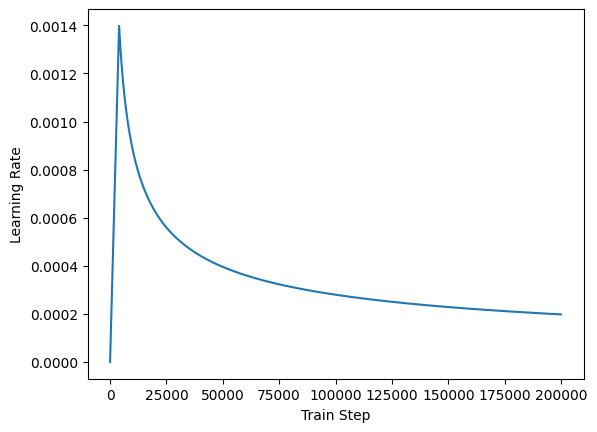

In [23]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
